<a href="https://colab.research.google.com/github/asheta66/CNN/blob/main/Breast_Diagnosis_Model_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
# !pip uninstall -y pandas tensorflow
# !pip install pandas tensorflow
# !pip install seaborn


In [59]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from PIL import Image
import itertools
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define your data directory path
data_dir = '/content/drive/My Drive/data2'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



Select the resolution:
1. 32x32
2. 56x56
3. 128x128
4. 256x256
5. 512x512

Enter the number corresponding to your choice: 1

Selected data directory: /content/drive/My Drive/data2/32x32
Selected resolution: (32, 32)

Class 'malignant': 360 images
Class 'benign': 537 images
Class 'normal': 133 images
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.4440 - loss: 1.0318 - val_accuracy: 0.5194 - val_loss: 0.9362
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5223 - loss: 0.9175 - val_accuracy: 0.5825 - val_loss: 0.9020
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5441 - loss: 0.8721 - val_accuracy: 0.6602 - val_loss: 0.7925
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6363 - loss: 0.7915 - val_accuracy: 0.6796 - val_loss: 0.7977
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6396 - loss: 0.7941 - val_accuracy: 0.6893 - val_loss: 0.7252
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6873 - loss: 0.7380 - val_accuracy: 0.7136 - val_loss: 0.6756
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6639 - loss: 0.7387 - val_accuracy: 0.7184 - val_loss: 0.6822
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7002 - loss: 0.6661 - val_accuracy: 0.7184 - val_loss: 0.

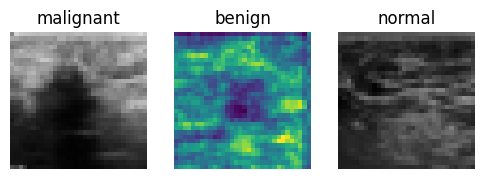

In [60]:
# Define possible resolution options and corresponding folder names
resolutionOptions = {
    '32x32': (32, 32),
    '56x56': (56, 56),
    '128x128': (128, 128),
    '256x256': (256, 256),
    '512x512': (512, 512)
}

# Ask the user to select a resolution
print("\nSelect the resolution:")
for i, (res_name, res_size) in enumerate(resolutionOptions.items(), 1):
    print(f"{i}. {res_name}")
print("")

selectionIndex = int(input("Enter the number corresponding to your choice: ")) - 1
if selectionIndex < 0 or selectionIndex >= len(resolutionOptions):
    raise ValueError("Invalid selection. Exiting.")

# Construct the data directory path and resolution based on the selected resolution
selectedResolutionName = list(resolutionOptions.keys())[selectionIndex]
selectedResolutionSize = resolutionOptions[selectedResolutionName]
data_dir = os.path.join('/content/drive/My Drive/data2', selectedResolutionName)

# Display the selected directory path and resolution
print(f"\nSelected data directory: {data_dir}")
print(f"Selected resolution: {selectedResolutionSize}\n")

# Check if the data directory exists
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Directory '{data_dir}' does not exist.")

# Get the list of class names (subfolders)
classes = [cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls))]

for cls in classes:
    cls_dir = os.path.join(data_dir, cls)
    num_images = len(os.listdir(cls_dir))
    print(f"Class '{cls}': {num_images} images")

# Function to build and compile the CNN model
def build_compile_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])  # Ensure 'accuracy' is used
    return model

# Function to load a single image
def load_image(directory, cls, img_file):
    img_path = os.path.join(directory, cls, img_file)
    img = Image.open(img_path)
    return img

# Prepare data
X, y = [], []
label_map = {cls: idx for idx, cls in enumerate(classes)}

for cls in classes:
    cls_dir = os.path.join(data_dir, cls)
    img_files = os.listdir(cls_dir)

    for img_file in img_files:
        img_path = os.path.join(cls_dir, img_file)
        img = load_img(img_path, target_size=selectedResolutionSize)
        img_array = img_to_array(img)
        X.append(img_array)
        y.append(label_map[cls])

X = np.array(X).astype('float32') / 255.0
y = np.array(y).astype('int')

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=22)

input_shape = (selectedResolutionSize[0], selectedResolutionSize[1], 3)
num_classes = len(classes)

# Build and compile model
model = build_compile_model(input_shape, num_classes)

# Train the model with validation split
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

# Predict and evaluate
y_train_pred = np.argmax(model.predict(X_train), axis=1)
y_test_pred = np.argmax(model.predict(X_test), axis=1)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

report_train = classification_report(y_train, y_train_pred, target_names=classes)
report_test = classification_report(y_test, y_test_pred, target_names=classes)

# Save the CNN architecture as a PNG figure
plot_model(model, to_file=f'model_architecture_{selectedResolutionSize[0]}x{selectedResolutionSize[1]}.png', show_shapes=True, show_layer_names=True)

# Draw a sample image (one image from each class)
fig, axes = plt.subplots(1, len(classes), figsize=(6, 6))
for ax, cls in zip(axes, classes):
    img_file = random.choice(os.listdir(os.path.join(data_dir, cls)))
    img = load_image(data_dir, cls, img_file)
    ax.imshow(img)
    ax.set_title(cls)
    ax.axis('off')


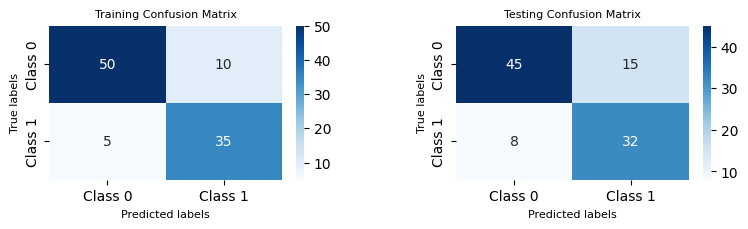

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrices(cm_train, cm_test, class_names,
                            train_title='Training Confusion Matrix',
                            test_title='Testing Confusion Matrix',
                            filename='confusion_matrices.png',
                            font_size=12):
    """
    Plots and saves confusion matrices for training and testing datasets.

    Parameters:
    - cm_train: Confusion matrix for the training set.
    - cm_test: Confusion matrix for the testing set.
    - class_names: List of class names.
    - train_title: Title for the training confusion matrix plot.
    - test_title: Title for the testing confusion matrix plot.
    - filename: File name for saving the plot.
    - font_size: Font size for the plot labels.
    """

    fig, axes = plt.subplots(1, 2, figsize=(9, 2))
    plt.subplots_adjust(wspace=0.4)

    # Plot training confusion matrix
    sns.heatmap(cm_train, annot=True, fmt='d', ax=axes[0],
                cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    axes[0].set_xlabel('Predicted labels', fontsize=font_size)
    axes[0].set_ylabel('True labels', fontsize=font_size)
    axes[0].set_title(train_title, fontsize=font_size)

    # Plot testing confusion matrix
    sns.heatmap(cm_test, annot=True, fmt='d', ax=axes[1],
                cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    axes[1].set_xlabel('Predicted labels', fontsize=font_size)
    axes[1].set_ylabel('True labels', fontsize=font_size)
    axes[1].set_title(test_title, fontsize=font_size)

    # Save the figure
    plt.savefig(filename, bbox_inches='tight')

    # Display the figure
    plt.show()

    # Close the plot
    plt.close()

# Sample confusion matrices and class names
cm_train = np.array([[50, 10], [5, 35]])
cm_test = np.array([[45, 15], [8, 32]])
classes = ['Class 0', 'Class 1']
selectedResolutionSize = [32, 32]  # Example resolution size

# Usage of the function
plot_confusion_matrices(cm_train, cm_test, classes,
                        train_title='Training Confusion Matrix',
                        test_title='Testing Confusion Matrix',
                        filename=f'confusion_matrices_{selectedResolutionSize[0]}x{selectedResolutionSize[1]}.png',
                        font_size=8)


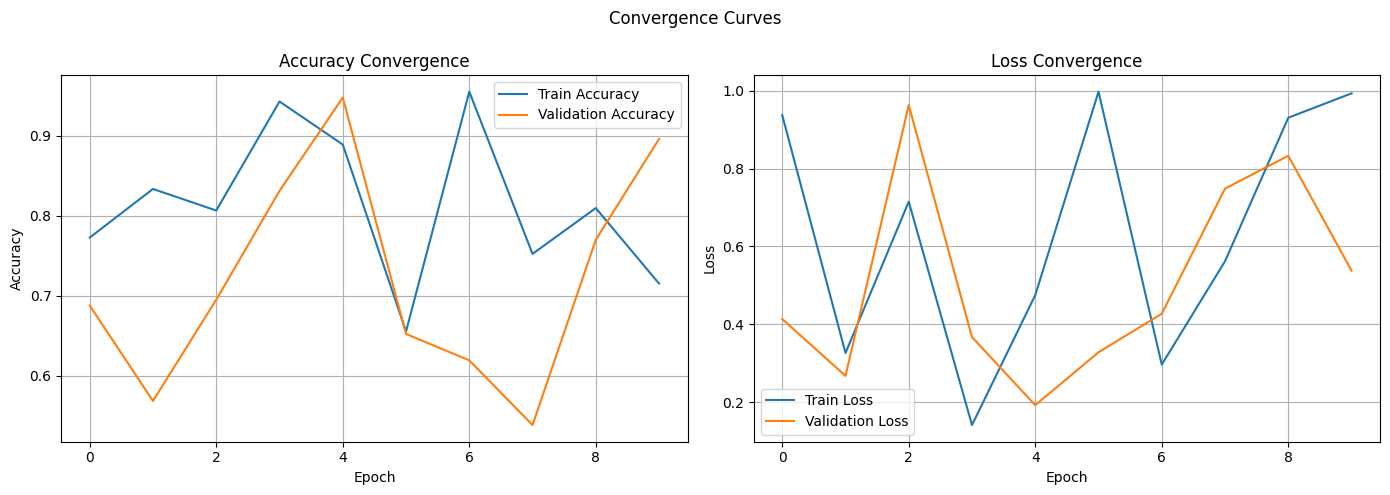

In [62]:
import matplotlib.pyplot as plt
import numpy as np

def plot_convergence_curves(history, filename='convergence_curves.png', title='Convergence Curves'):
    """
    Plots convergence curves for training and validation metrics, and saves the figure.

    Parameters:
    - history: The History object returned by model.fit(), which contains training and validation metrics.
    - filename: File name for saving the plot.
    - title: Title for the plot.
    """
    # Create a figure with two subplots: one for accuracy and one for loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot accuracy
    if 'accuracy' in history.history:
        ax1.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history:
        ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy Convergence')
    ax1.legend()
    ax1.grid()

    # Plot loss
    if 'loss' in history.history:
        ax2.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Loss Convergence')
    ax2.legend()
    ax2.grid()

    # Set the overall title and layout
    fig.suptitle(title)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust the top to fit the title

    # Save the figure
    plt.savefig(filename, bbox_inches='tight')

    # Display the figure
    plt.show()

    # Close the plot
    plt.close()

# Mock history object for demonstration
class MockHistory:
    def __init__(self):
        self.history = {
            'accuracy': np.random.uniform(0.5, 1, 10),
            'val_accuracy': np.random.uniform(0.5, 1, 10),
            'loss': np.random.uniform(0.1, 1, 10),
            'val_loss': np.random.uniform(0.1, 1, 10)
        }

# Example resolution size
selectedResolutionSize = [32, 32]

# Usage of the function
history = MockHistory()
plot_convergence_curves(history, filename=f'convergence_curves_{selectedResolutionSize[0]}x{selectedResolutionSize[1]}.png', title='Convergence Curves')


In [63]:
# Initialize a list to store metrics for saving
metrics = []

# After training and predictions
train_predictions = np.argmax(model.predict(X_train), axis=1)
test_predictions = np.argmax(model.predict(X_test), axis=1)

# Compute metrics for training data
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions, average='weighted')
train_recall = recall_score(y_train, train_predictions, average='weighted')
train_f1 = f1_score(y_train, train_predictions, average='weighted')

# Store training metrics in the list
metrics.append({
    'Dataset': 'Training',
    'Resolution': f'{selectedResolutionSize[0]}x{selectedResolutionSize[1]}',
    'Accuracy': train_accuracy,
    'Precision': train_precision,
    'Recall': train_recall,
    'F1 Score': train_f1
})

# Compute metrics for testing data
test_accuracy = accuracy_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions, average='weighted')
test_recall = recall_score(y_test, test_predictions, average='weighted')
test_f1 = f1_score(y_test, test_predictions, average='weighted')

# Store testing metrics in the list
metrics.append({
    'Dataset': 'Testing',
    'Resolution': f'{selectedResolutionSize[0]}x{selectedResolutionSize[1]}',
    'Accuracy': test_accuracy,
    'Precision': test_precision,
    'Recall': test_recall,
    'F1 Score': test_f1
})

# Create a DataFrame from the metrics list
metrics_df = pd.DataFrame(metrics)

# Display metrics DataFrame
print(metrics_df)

# Define filename with resolution
excel_filename = f'performance_metrics_{selectedResolutionSize[0]}x{selectedResolutionSize[1]}.xlsx'

# Save the DataFrame to an Excel file
metrics_df.to_excel(excel_filename, index=False, sheet_name='Performance Metrics')

print(f"Metrics saved to {excel_filename}")


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
    Dataset Resolution  Accuracy  Precision    Recall  F1 Score
0  Training      32x32  0.996359   0.996368  0.996359  0.996360
1   Testing      32x32  0.859223   0.859426  0.859223  0.859226
Metrics saved to performance_metrics_32x32.xlsx
